# Alpha Algorithm

In [1]:
import pandas as pd
from collections import defaultdict

In [2]:
# aalst traces
#traces = [
#    ["a", "b", "c", "d"],
#    ["a", "c", "b", "d"],
#    ["a", "e", "d"]
#]

# rehse traces
traces = [
    ["a", "c", "d", "e"],
    ["b", "c", "d", "e"],
    ["a", "c", "e", "d"],
    ["b", "c", "e", "d"]
]

In [3]:
def get_activities(traces):
    """
    Get activity informations from traces.
    Returns set for all_activities, start_activities, end_activities and dict for direct_successions
    """
    start_activities = set()
    end_activities = set()
    all_activities = set()
    
    direct_successions = defaultdict(set)
    
    # go through all our traces
    for trace in traces:
        # add start and end activities
        start_activities.add(trace[0])
        end_activities.add(trace[-1])
        
        # add activities of trace to all activities
        all_activities.update(trace)
        
        # go through all activities in our trace and 
        for idx, activity in enumerate(trace[1:], start=1):
            direct_successions[trace[idx - 1]].add(activity)
    
    return all_activities, start_activities, end_activities, direct_successions

In [4]:
all_activities, start_activities, end_activities, direct_successions = get_activities(traces)

## Step 1
![Step 1](img/Step_1.png)

#### Set of All Activities

In [5]:
all_activities

{'a', 'b', 'c', 'd', 'e'}

## Step 2
![Step 2](img/Step_2.png)

#### Set of Start Activities

In [6]:
start_activities

{'a', 'b'}

## Step 3
![Step 3](img/Step_3.png)

#### Set of End Activities

In [7]:
end_activities

{'d', 'e'}

## Step 4
![Step 4](img/Step_4.png)


#### Create Footprint Matrix

In [8]:
def get_footprint(all_activities, direct_successions):
    all_activities = sorted(list(all_activities))
    footprint = []
    
    for x in all_activities:
        row = []
        for y in all_activities:
            x_follows_y = x in direct_successions[y]
            y_follows_x = y in direct_successions[x]
            
            if y_follows_x and not x_follows_y:
                row.append("→")
            elif x_follows_y and not y_follows_x:
                row.append("←")
            elif x_follows_y and y_follows_x:
                row.append("||")
            else:
                row.append("#")
        footprint.append(row)
        
    footprint_df = pd.DataFrame(footprint, columns=all_activities, index=all_activities)
    return footprint_df

In [9]:
footprint = get_footprint(all_activities, direct_successions)
footprint

,a,b,c,d,e
a,#,#,→,#,#
b,#,#,→,#,#
c,←,←,#,→,→
d,#,#,←,#,||
e,#,#,←,||,#


#### Get all Pairs

In [10]:
def is_mergeable(p, q):
    """Check if two pairs are mergeable"""
    
    for pa in p[0]:
        # every activity in a must be #-(choice)-relation with every other element in a
        for qa in q[0]:
            if footprint[qa][pa] != "#":
                return False
        
        # every activity in a must be in →-(causality)-relation with every activity in b
        for qb in q[1]:
            if footprint[qb][pa] != "→":
                return False
    
    for pb in p[1]:
        # every activity in b must be #-(choice)-relation with every other element in b
        for qb in q[1]:
            if footprint[pb][qb] != "#":
                return False

        # every activity in a must be in →-(causality)-relation with every activity in b
        for qa in q[0]:
            if footprint[pb][qa] != "→":
                return False
            
    return True
              
def merge_pairs(p, q):
    a = set(p[0])
    a.update(q[0])
    
    b = set(p[1])
    b.update(q[1])

    return (a, b)
    
def find_pairs(footprint):
    # get all →-(causality)-relations
    pairs = [({footprint[col][footprint[col] == "→"].index[i]}, {col}) 
             for col in footprint.columns for i in range(len(footprint[col][footprint[col] == '→'].index))]
    idx = 0
    while idx < len(pairs):
        p = pairs[idx]
        for q in pairs[idx+1:]:
            # check if the pairs can be merged
            if is_mergeable(p, q):
                # create and add the merged pair to pairs
                merged_pair = merge_pairs(p, q)
                if merged_pair not in pairs:
                    pairs.append(merged_pair)
        idx += 1
    return pairs

In [11]:
all_pairs = find_pairs(footprint)
all_pairs

[({'a'}, {'c'}),
 ({'b'}, {'c'}),
 ({'c'}, {'d'}),
 ({'c'}, {'e'}),
 ({'a', 'b'}, {'c'})]

## Step 5
![Step 5](img/Step_5.png)

#### Remove non-maximal Pairs

In [12]:
def remove_non_maximal_pairs(pairs):
    pairs = pairs.copy()
    idx = 0
    while idx < len(pairs) - 1:
        p = pairs[idx]
        non_max = False
        for q in pairs[idx+1:]:
            # check if current pair is a subset of another pair, if yes, remove pair
            if p[0].issubset(q[0]) and p[1].issubset(q[1]):
                pairs.pop(idx)
                non_max = True
                break
        if not non_max:
            idx += 1
    return pairs
               
maximal_pairs = remove_non_maximal_pairs(all_pairs)
maximal_pairs

[({'c'}, {'d'}), ({'c'}, {'e'}), ({'a', 'b'}, {'c'})]

## Step 6 - 9
![Step 6-8](img/Step_6-8.png)

#### Create a PetriNet

In [13]:
from pm4py.objects.petri.obj import PetriNet, Marking
from pm4py.objects.petri import utils
from pm4py.visualization.petrinet import visualizer as pn_visualizer

net = PetriNet("Example: Rehse")

#### Add Initial and Final Place

In [14]:
# create and add places
source = PetriNet.Place("start")
net.places.add(source)
sink = PetriNet.Place("end")
net.places.add(sink)

# add tokens
initial_marking = Marking()
initial_marking[source] = 1
final_marking = Marking()
final_marking[sink] = 1

#### Add Transitions for all Activities

In [15]:
transitionMap = {}
for activity in all_activities:
    transition = PetriNet.Transition(activity, activity)
    net.transitions.add(transition)
    transitionMap[activity] = transition

#### Add Input Arc from Start Place (Source) to Start Activities/Transitions

In [16]:
for activity in start_activities:
    utils.add_arc_from_to(source, transitionMap[activity], net)
    

#### Add Output Arc from End Activities/Transitions to End Place (Sink)

In [17]:
for activity in end_activities:
    utils.add_arc_from_to(transitionMap[activity], sink, net)

#### Add Input and Output Arcs for all our Pairs

In [18]:
for idx, pair in enumerate(maximal_pairs, start=1):
    place = PetriNet.Place("p%d"%idx)
    net.places.add(place)
    
    for a in pair[0]:
        utils.add_arc_from_to(transitionMap[a], place, net)
    
    for b in pair[1]:
        utils.add_arc_from_to(place, transitionMap[b], net)

#### Draw our PetriNet

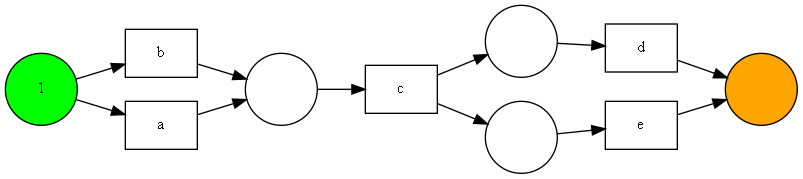

In [19]:
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)